# Lab IS&A
## Bagattin Enrico - Alessandro Doretto

In [2]:
# Import
import pandas as pd
import numpy as np
import glob

# Modules
from utilities import *
from dataPreparation import *

In [2]:
# Import data
years = [2017, 2018, 2019, 2020]
yearsForFeatures = [2016, 2017, 2018, 2019, 2020]
paths = []
for y in years:
    paths.append('matches/' + str(y) + '.xlsx') 
availablePaths = list(glob.glob("matches/20*.xlsx"))
matches = [pd.read_excel(path) for path in paths]
yearZeroForFeatures = pd.read_excel('matches/' + str(years[0]-1) + '.xlsx')
# TODO: Load matches based on number of past years choosen
df = pd.concat(matches, ignore_index=True, sort=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8254 entries, 0 to 8253
Data columns (total 40 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ATP         8254 non-null   int64         
 1   Location    8254 non-null   object        
 2   Tournament  8254 non-null   object        
 3   Date        8254 non-null   datetime64[ns]
 4   Series      8254 non-null   object        
 5   Court       8254 non-null   object        
 6   Surface     8254 non-null   object        
 7   Round       8254 non-null   object        
 8   Best of     8254 non-null   int64         
 9   Winner      8254 non-null   object        
 10  Loser       8254 non-null   object        
 11  WRank       8250 non-null   float64       
 12  LRank       8230 non-null   float64       
 13  WPts        8251 non-null   float64       
 14  LPts        8230 non-null   float64       
 15  W1          8199 non-null   float64       
 16  L1          8201 non-nul

In [3]:
df.head().T

,0,1,2,3,4
ATP,1,1,1,1,1
Location,Brisbane,Brisbane,Brisbane,Brisbane,Brisbane
Tournament,Brisbane International,Brisbane International,Brisbane International,Brisbane International,Brisbane International
Date,2017-01-01 00:00:00,2017-01-02 00:00:00,2017-01-02 00:00:00,2017-01-02 00:00:00,2017-01-02 00:00:00
Series,ATP250,ATP250,ATP250,ATP250,ATP250
Court,Outdoor,Outdoor,Outdoor,Outdoor,Outdoor
Surface,Hard,Hard,Hard,Hard,Hard
Round,1st Round,1st Round,1st Round,1st Round,1st Round
Best of,3,3,3,3,3
Winner,Thompson J.,Mahut N.,Ferrer D.,Edmund K.,Dimitrov G.


In [4]:
df.describe(include='all', percentiles=[]).T

,count,unique,top,freq,mean,std,min,50%,max,first,last
ATP,8254,NaN,NaN,NaN,32.2989,18.9789,1,32,67,NaT,NaT
Location,8254,70,Paris,522,NaN,NaN,NaN,NaN,NaN,NaT,NaT
Tournament,8254,81,Australian Open,508,NaN,NaN,NaN,NaN,NaN,NaT,NaT
Date,8254,882,2020-01-21 00:00:00,51,NaN,NaN,NaN,NaN,NaN,2017-01-01,2020-02-16
Series,8254,5,ATP250,3521,NaN,NaN,NaN,NaN,NaN,NaT,NaT
Court,8254,2,Outdoor,6894,NaN,NaN,NaN,NaN,NaN,NaT,NaT
Surface,8254,3,Hard,4829,NaN,NaN,NaN,NaN,NaN,NaT,NaT
Round,8254,8,1st Round,3712,NaN,NaN,NaN,NaN,NaN,NaT,NaT
Best of,8254,NaN,NaN,NaN,3.39932,0.799539,3,3,5,NaT,NaT
Winner,8254,311,Nadal R.,166,NaN,NaN,NaN,NaN,NaN,NaT,NaT


# Cleaning and preparing data

## Remove Winner/Loser reference
All the column with Winner/Loser reference will be substituted by Player0/Player1.

In [5]:
df = removeWinnerLoserReference(df)
yearZeroForFeatures = removeWinnerLoserReference(yearZeroForFeatures)

## Filling null:
* Rank: take the max rank plus one
* Pts: set default zero	
* Avg odd: take mode of matches with same (or similar) players rank
* B365, PS: fill with avg

In [6]:
rankDefault = max(df['Rank0'].max(), df['Rank1'].max())+1
df.fillna({'Rank0': rankDefault, 'Rank1': rankDefault, 'Pts0': 0, 'Pts1': 0}, inplace=True)

nullOddsDf = df[df[['B3650', 'B3651', 'PS0', 'PS1', 'Avg0', 'Avg1']].isna().any(axis=1)]
for index, row in nullOddsDf.iterrows():
    if pd.isnull(row['Avg0']) or pd.isnull(row['Avg1']):
        Avg0, Avg1 = findOddsForRow(row, df.dropna(subset=['Avg0', 'Avg1']))
        df.at[index, 'Avg0'] = row['Avg0'] = Avg0
        df.at[index, 'Avg1'] = row['Avg1'] = Avg1
    if pd.isnull(row['B3650']):
        df.at[index, 'B3650'] = row['Avg0']
    if pd.isnull(row['B3651']):
        df.at[index, 'B3651'] = row['Avg1']
    if pd.isnull(row['PS0']):
        df.at[index, 'PS0'] = row['Avg0']
    if pd.isnull(row['PS1']):
        df.at[index, 'PS1'] = row['Avg1']

df.dropna(subset=['Avg0', 'Avg1'], inplace=True) # Drop rows that hasn't similar rank matches
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8254 entries, 0 to 8253
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        8254 non-null   datetime64[ns]
 1   Location    8254 non-null   object        
 2   Tournament  8254 non-null   object        
 3   Series      8254 non-null   object        
 4   Court       8254 non-null   object        
 5   Surface     8254 non-null   object        
 6   Round       8254 non-null   object        
 7   Player0     8254 non-null   object        
 8   Player1     8254 non-null   object        
 9   Rank0       8254 non-null   float64       
 10  Rank1       8254 non-null   float64       
 11  Pts0        8254 non-null   float64       
 12  Pts1        8254 non-null   float64       
 13  Comment     8254 non-null   object        
 14  B3650       8254 non-null   float64       
 15  B3651       8254 non-null   float64       
 16  PS0         8254 non-nul

## New features
* [Elo rating](https://en.wikipedia.org/wiki/Elo_rating_system): a method for calculating the relative skill levels of players in zero-sum games
* Number of matches played during the last year
* Percentage of matches won during the last year
* Injuries: number matches in witch the player retired or walkover in the past year 
* Winning streak: current sequence of won games

In [7]:
X = addEloRatingFeature(df)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Progress: |██████████████████████████████████████████████████| 100.0% Complete


In [8]:
X = addMatchesPlayedAndWonFeatures(X, yearZeroForFeatures, yearsForFeatures)

Progress: |██████████████████████████████████████████████████| 100.0% Complete


In [9]:
X = addInjuriesAndWinningStreakFeatures(X, yearZeroForFeatures, yearsForFeatures)

Progress: |██████████████████████████████████████████████████| 100.0% Complete


In [10]:
X.to_csv('generated/beforeDuplication.csv', index=False)

## Row duplication
To use both match outcomes for our prediction models we will duplicate each row. We can do it by switching all the player features for each duplicated row and adding a Winner column for the match result

In [11]:
X.columns

Index(['Date', 'Location', 'Tournament', 'Series', 'Court', 'Surface', 'Round',
       'Player0', 'Player1', 'Rank0', 'Rank1', 'Pts0', 'Pts1', 'Comment',
       'B3650', 'B3651', 'PS0', 'PS1', 'Avg0', 'Avg1', 'EloRating0',
       'EloRating1', 'MatchesPlayed0', 'MatchesPlayed1', 'MatchesWon0',
       'MatchesWon1', 'Injuries0', 'Injuries1', 'WinningStreak0',
       'WinningStreak1'],
      dtype='object')

In [12]:
duplication = X.copy()
duplication.columns = ['Date', 'Location', 'Tournament', 'Series', 'Court', 'Surface', 'Round',
       'Player1', 'Player0', 'Rank1', 'Rank0', 'Pts1', 'Pts0', 'Comment',
       'B3651', 'B3650', 'PS1', 'PS0', 'Avg1', 'Avg0', 'EloRating1',
       'EloRating0', 'MatchesPlayed1', 'MatchesPlayed0', 'MatchesWon1',
       'MatchesWon0', 'Injuries1', 'Injuries0', 'WinningStreak1',
       'WinningStreak0']

# Add the winner column
X = X.assign(Winner=np.zeros(X.shape[0])) # Player 0 always win
duplication = duplication.assign(Winner=np.ones(X.shape[0])) # Player 1 always win

X = pd.concat([X, duplication])
X.reset_index(inplace=True)
X.sort_values(by='index', inplace=True)
X.drop(columns=['Date', 'Comment', 'index'], inplace=True)

## One hot encoding
* Location
* Tournament
* Series
* Court
* Surface
* Round
* Players

In [13]:
X = pd.get_dummies(X)
print('Total number of columns:', len(X.columns))

X.to_csv('generated/finalDataset.csv', index=False)


Total number of columns: 1064


## Dataset subdivision: Train, Validation, Test

Train 60%, Validation 20%, Test 20% (taking as test the last part of the dataset)

In [3]:
import pandas as pd

X = pd.read_csv('generated/finalDataset.csv')

X.head()

,Rank0,Rank1,Pts0,Pts1,B3650,B3651,PS0,PS1,Avg0,Avg1,...,Player1_Zayid M.S.,Player1_Zeballos H.,Player1_Zekic M.,Player1_Zhang Ze,Player1_Zhang Ze.,Player1_Zhang Zh.,Player1_Zopp J.,Player1_Zverev A.,Player1_Zverev A.,Player1_Zverev M.
0,79.0,160.0,689.0,372.0,1.28,3.50,1.31,3.73,1.29,3.50,...,0,0,0,0,0,0,0,0,0,0
1,160.0,79.0,372.0,689.0,3.50,1.28,3.73,1.31,3.50,1.29,...,0,0,0,0,0,0,0,0,0,0
2,54.0,39.0,854.0,1102.0,2.50,1.50,2.52,1.58,2.43,1.54,...,0,0,0,0,0,0,0,0,0,0
3,39.0,54.0,1102.0,854.0,1.50,2.50,1.58,2.52,1.54,2.43,...,0,0,0,0,0,0,0,0,0,0
4,21.0,26.0,1785.0,1465.0,1.90,1.80,2.10,1.81,2.01,1.77,...,0,0,0,0,0,0,0,0,0,0


In [4]:
from sklearn.model_selection import train_test_split

y = X.Winner.values
X.drop(columns='Winner', inplace=True)

test_size = len(X)//5
X_test     = X[-test_size:]
y_test     = y[-test_size:]
X_train_80 = X[:-test_size]
y_train_80 = y[:-test_size]

# Random split for training and validation
X_train, X_valid, y_train, y_valid = train_test_split(X_train_80, y_train_80, test_size=0.25, random_state=42)

# Prediction models
We start by calculating how much powerful are the bookmakers' alghoritms, then we create and tune ours, let's see the results
## Baseline
Our first goal is to beat the average bookmaker accuracy

In [16]:
from sklearn.metrics import accuracy_score

#Player 1 wins if the odd is smaller than player 0
baseline = X_test['Avg1'] < X_test['Avg0']
baseline = baseline.astype(int)
baseline_test_acc = accuracy_score(y_true=y_test, y_pred=baseline)
print ("Test Accuracy: {:.2f}".format(baseline_test_acc*100), "%")

Test Accuracy: 68.46 %


In [5]:
accuraciesForModels = {'kNN': [], 'Naive Bayes': [], 'Decision Tree': [], 'Random Forest': []}

## k-Nearest-Neighbor Classifier

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
scaled_train = scaler.transform(X_train)
scaled_valid = scaler.transform(X_valid)
scaled_train_80 = scaler.transform(X_train_80)
scaled_test = scaler.transform(X_test)

In [22]:
# Warning: kNN is very slow with this dataset

from sklearn import neighbors
from sklearn.metrics import accuracy_score

accuracies = []

for k in range(1,16):
    kNN = neighbors.KNeighborsClassifier(n_neighbors=k)
    kNN.fit(scaled_train, y_train)
    y_pred = kNN.predict(scaled_valid)
    valid_acc = accuracy_score(y_true=y_valid, y_pred=y_pred)
    print ("k: {:2d} | Validation Accuracy: {:.3f}".format(k, valid_acc))
    accuracies += [[valid_acc, k]]

k:  1 | Validation Accuracy: 0.519
k:  2 | Validation Accuracy: 0.531
k:  3 | Validation Accuracy: 0.548
k:  4 | Validation Accuracy: 0.555
k:  5 | Validation Accuracy: 0.570
k:  6 | Validation Accuracy: 0.571
k:  7 | Validation Accuracy: 0.590
k:  8 | Validation Accuracy: 0.581
k:  9 | Validation Accuracy: 0.591
k: 10 | Validation Accuracy: 0.581
k: 11 | Validation Accuracy: 0.591
k: 12 | Validation Accuracy: 0.589
k: 13 | Validation Accuracy: 0.595
k: 14 | Validation Accuracy: 0.588
k: 15 | Validation Accuracy: 0.591


In [6]:
# All the resulting accuracies for a faster running process purpose

accuracies =   [[0.519, 1],
                [0.531, 2],
                [0.548, 3],
                [0.555, 4],
                [0.570, 5],
                [0.571, 6],
                [0.590, 7],
                [0.581, 8],
                [0.591, 9],
                [0.581, 10],
                [0.591, 11],
                [0.589, 12],
                [0.595, 13],
                [0.588, 14],
                [0.591, 15]]

accuraciesForModels['kNN'] = accuracies

In [11]:
from sklearn import neighbors
from sklearn.metrics import accuracy_score

best_accuracy, best_k = max(accuracies)
print ( "Best K", best_k )

kNN = neighbors.KNeighborsClassifier(n_neighbors=best_k)
kNN.fit(scaled_train_80, y_train_80)

test_acc = accuracy_score(y_true=y_test, y_pred=kNN.predict(scaled_test))
print ("Test Accuracy: {:.3f}".format(test_acc))

Best K 13
Test Accuracy: 0.578


## Naive Bayes

In [12]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# Train and predict
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# Compute accuracy
train_acc = accuracy_score(y_true=y_train, y_pred=gnb.predict(X_train))
valid_acc = accuracy_score(y_true=y_valid, y_pred=gnb.predict(X_valid))
print ("Train Accuracy: {:.3f} - Validation Accuracy: {:.3f}".format(train_acc, valid_acc))

gnb.fit(X_train_80,y_train_80)

# Finally evaluate on test
test_acc = accuracy_score(y_true=y_test, y_pred=gnb.predict(X_test))
print ("Test Accuracy: {:.3f}".format(test_acc))

accuraciesForModels['Naive Bayes'] = [[valid_acc, 50]]

Train Accuracy: 0.684 - Validation Accuracy: 0.629
Test Accuracy: 0.630


## Decision Tree

In [13]:
from sklearn import tree
from sklearn.metrics import accuracy_score

accuracies = []

for max_leaves in range(5, 101, 5):
    # train and predict
    dt = tree.DecisionTreeClassifier(max_leaf_nodes=max_leaves)
    dt.fit(X_train, y_train)

    # compute Accuracy
    train_acc = accuracy_score(y_true=y_train, y_pred=dt.predict(X_train))
    valid_acc = accuracy_score(y_true=y_valid, y_pred=dt.predict(X_valid))
    print ("Leaves: {:2d} - Train Accuracy: {:.3f} - Validation Accuracy: {:.3f}".format(
        max_leaves,  train_acc, valid_acc) )
    
    accuracies += [ [valid_acc, max_leaves] ]

best_accuracy, best_max_leaves = max(accuracies)
print ( "Best Max Leaves", best_max_leaves )

# here we are using both training and validation,
# to exploit the most data
dt = tree.DecisionTreeClassifier(max_leaf_nodes=best_max_leaves)
dt.fit(X_train_80,y_train_80)

# Finally evaluate on test
test_acc = accuracy_score(y_true=y_test, y_pred=dt.predict(X_test))
print ("Test Accuracy: {:.3f}".format(test_acc))

accuraciesForModels['Decision Tree'] = accuracies

Leaves:  5 - Train Accuracy: 0.677 - Validation Accuracy: 0.684
Leaves: 10 - Train Accuracy: 0.677 - Validation Accuracy: 0.668
Leaves: 15 - Train Accuracy: 0.680 - Validation Accuracy: 0.667
Leaves: 20 - Train Accuracy: 0.681 - Validation Accuracy: 0.668
Leaves: 25 - Train Accuracy: 0.685 - Validation Accuracy: 0.667
Leaves: 30 - Train Accuracy: 0.689 - Validation Accuracy: 0.675
Leaves: 35 - Train Accuracy: 0.690 - Validation Accuracy: 0.674
Leaves: 40 - Train Accuracy: 0.693 - Validation Accuracy: 0.675
Leaves: 45 - Train Accuracy: 0.697 - Validation Accuracy: 0.675
Leaves: 50 - Train Accuracy: 0.699 - Validation Accuracy: 0.675
Leaves: 55 - Train Accuracy: 0.701 - Validation Accuracy: 0.674
Leaves: 60 - Train Accuracy: 0.703 - Validation Accuracy: 0.671
Leaves: 65 - Train Accuracy: 0.704 - Validation Accuracy: 0.671
Leaves: 70 - Train Accuracy: 0.704 - Validation Accuracy: 0.669
Leaves: 75 - Train Accuracy: 0.706 - Validation Accuracy: 0.670
Leaves: 80 - Train Accuracy: 0.708 - Val

## Random Forest

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from sklearn import tree
from sklearn.metrics import accuracy_score

accuracies = []

for estimators in range(1, 150, 4):
    # train a decision tree classifier
    rf = RandomForestClassifier(n_estimators=estimators)
    rf.fit(X_train, y_train)

    # compute Accuracy
    train_acc = accuracy_score(y_true=y_train, y_pred=rf.predict(X_train))
    valid_acc = accuracy_score(y_true=y_valid, y_pred=rf.predict(X_valid))
    print ("Number of Trees: {:2d} - Train Accuracy: {:.3f} - Validation Accuracy: {:.3f}".format(
        estimators,  train_acc, valid_acc) )
    
    accuracies += [ [valid_acc, estimators] ]

best_accuracy, best_estimators = max(accuracies)
print ( "Best Number of Trees", best_estimators )

# here we are using both training and validation,
# to exploit the most data
rf = tree.DecisionTreeClassifier(max_leaf_nodes=best_estimators)
rf.fit(X_train_80,y_train_80)

# Finally evaluate on test
test_acc = accuracy_score(y_true=y_test, y_pred=rf.predict(X_test))
print ("Test Accuracy: {:.3f}".format(test_acc))

accuraciesForModels['Random Forest'] = accuracies

Number of Trees:  1 - Train Accuracy: 0.845 - Validation Accuracy: 0.581
Number of Trees:  5 - Train Accuracy: 0.955 - Validation Accuracy: 0.639
Number of Trees:  9 - Train Accuracy: 0.982 - Validation Accuracy: 0.642
Number of Trees: 13 - Train Accuracy: 0.991 - Validation Accuracy: 0.647
Number of Trees: 17 - Train Accuracy: 0.995 - Validation Accuracy: 0.650
Number of Trees: 21 - Train Accuracy: 0.997 - Validation Accuracy: 0.664
Number of Trees: 25 - Train Accuracy: 0.998 - Validation Accuracy: 0.671
Number of Trees: 29 - Train Accuracy: 0.999 - Validation Accuracy: 0.664
Number of Trees: 33 - Train Accuracy: 0.999 - Validation Accuracy: 0.672
Number of Trees: 37 - Train Accuracy: 0.999 - Validation Accuracy: 0.670
Number of Trees: 41 - Train Accuracy: 1.000 - Validation Accuracy: 0.669
Number of Trees: 45 - Train Accuracy: 1.000 - Validation Accuracy: 0.665
Number of Trees: 49 - Train Accuracy: 1.000 - Validation Accuracy: 0.672
Number of Trees: 53 - Train Accuracy: 1.000 - Valid

## Accuracy Results
Let's visualize all the results

In [15]:
cols = ['Model', 'Parameter', 'Accuracy']
accuraciesForPlots = pd.DataFrame(columns = cols)

for i, key in enumerate(accuraciesForModels):
    for el in accuraciesForModels[key]:
        accuraciesForPlots.loc[len(accuraciesForPlots)] = [key, el[1], el[0]]

accuraciesForPlots.head()

,Model,Parameter,Accuracy
0,kNN,1,0.519
1,kNN,2,0.531
2,kNN,3,0.548
3,kNN,4,0.555
4,kNN,5,0.570


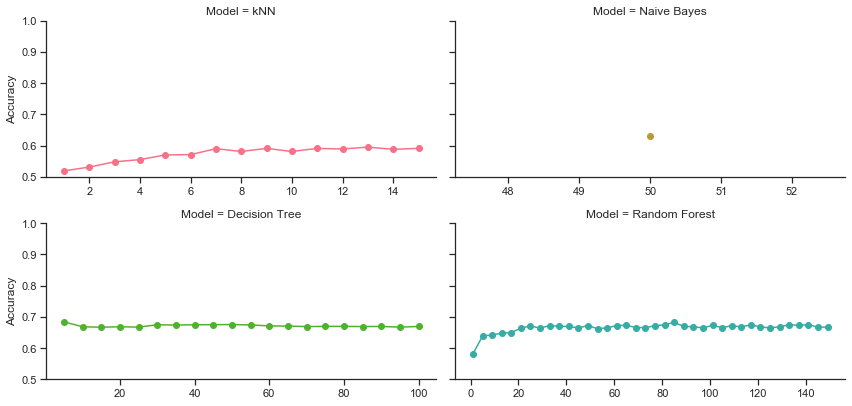

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="ticks")
sns.set_palette("husl")

grid = sns.FacetGrid(accuraciesForPlots, col="Model", aspect=2, ylim=(0.5, 1),
                     col_wrap=2, sharex=False, hue="Model")
grid.map(plt.axhline, y=0, ls=":", c=".5")
grid.map(plt.plot, 'Parameter', 'Accuracy', marker="o")
grid.set_axis_labels("", "Accuracy")

grid.savefig("generated/accuracies.png")

As we can see the kNN isn't very powerful with this type of predictions, the Naive Bayes model isn't bad but we can't tune it very much. So we will spend more effort with trying to increase the accuracy of the last two.

## Bias and Variance evaluation
We compute bias and variance by repeatedly training the models on different data samples.

### Decision Tree

In [33]:
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
import numpy as np

N_TESTS = 20

stats = pd.DataFrame(columns=['Trees', 'Type', 'Value'])
printProgressBar(0, 100, prefix='Progress:', suffix='Complete')

for max_leaves in range(5, 101, 5):
    y_preds = np.array([])
    
    for i in range(N_TESTS):
        Xs, ys = resample(X,y, n_samples=int(0.67*len(y)) )

        dt = DecisionTreeClassifier(max_leaf_nodes=max_leaves)
        dt.fit(Xs,ys)

        y_pred = dt.predict(X)
        y_preds = np.column_stack( [y_preds, y_pred] ) if y_preds.size else y_pred

    dt_bias     = (y-np.mean(y_preds,axis=1))**2
    dt_variance = np.var(y_preds,axis=1)
    dt_error    = (y_preds - y.reshape(-1,1))**2

    stats.loc[len(stats)] = [max_leaves, 'Error', dt_error.mean()]
    stats.loc[len(stats)] = [max_leaves, 'Bias', dt_bias.mean()]
    stats.loc[len(stats)] = [max_leaves, 'Variance', dt_variance.mean()]
    
    printProgressBar(max_leaves, 100, prefix='Progress:', suffix='Complete')


grid = sns.catplot(x='Trees', y='Value', hue='Type', kind='point', data=stats)
grid.set_axis_labels("Number of Leaves", "")

grid.savefig("generated/bias-variance-DT.png")

KeyboardInterrupt: 

As we can see from the results the variance seems to grow rapidly, so we can try to lower it using the bagging technique.

In [ ]:
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
import numpy as np

N_TESTS = 20

stats = pd.DataFrame(columns=['Trees', 'Type', 'Value'])
printProgressBar(0, 35, prefix='Progress:', suffix='Complete')

for b_rounds in range(5, 36, 5):
    y_preds = np.array([])
    
    for i in range(N_TESTS):
        Xs, ys = resample(X,y, n_samples=int(0.67*len(y)) )

        dt = BaggingClassifier(DecisionTreeClassifier(max_leaf_nodes=20), n_estimators=b_rounds)
        dt.fit(Xs,ys)

        y_pred = dt.predict(X)
        y_preds = np.column_stack( [y_preds, y_pred] ) if y_preds.size else y_pred

    dt_bias     = (y-np.mean(y_preds,axis=1))**2
    dt_variance = np.var(y_preds,axis=1)
    dt_error    = (y_preds - y.reshape(-1,1))**2

    stats.loc[len(stats)] = [b_rounds, 'Error', dt_error.mean()]
    stats.loc[len(stats)] = [b_rounds, 'Bias', dt_bias.mean()]
    stats.loc[len(stats)] = [b_rounds, 'Variance', dt_variance.mean()]
    
    printProgressBar(b_rounds, 35, prefix='Progress:', suffix='Complete')


grid = sns.catplot(x='Trees', y='Value', hue='Type', kind='point', data=stats)
grid.set_axis_labels("Bagging Rounds", "")

grid.savefig("generated/bias-variance-DT-bagging.png")

### Random Forest

In [ ]:
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
import numpy as np

N_TESTS = 20

stats = pd.DataFrame(columns=['Trees', 'Type', 'Value'])
printProgressBar(0, 97-45, prefix='Progress:', suffix='Complete')

for l in range(45, 100, 4):
    y_preds = np.array([])
    
    for i in range(N_TESTS):
        Xs, ys = resample(X,y, n_samples=int(0.67*len(y)) )

        rf = RandomForestClassifier(n_estimators=l)
        rf.fit(Xs,ys)

        y_pred = rf.predict(X)
        y_preds = np.column_stack( [y_preds, y_pred] ) if y_preds.size else y_pred

    rf_bias     = (y-np.mean(y_preds,axis=1))**2
    rf_variance = np.var(y_preds,axis=1)
    rf_error    = (y_preds - y.reshape(-1,1))**2

    stats.loc[len(stats)] = [l, 'Error', rf_error.mean()]
    stats.loc[len(stats)] = [l, 'Bias', rf_bias.mean()]
    stats.loc[len(stats)] = [l, 'Variance', rf_variance.mean()]
    
    printProgressBar(l, 97-45, prefix='Progress:', suffix='Complete')


grid = sns.catplot(x='Trees', y='Value', hue='Type', kind='point', data=stats)
grid.set_axis_labels("Number of Trees", "")

grid.savefig("generated/bias-variance-RF.png")

Progress: |██████████████████████████████████████████████████| 100.0% Complete


## Further improvements

We can see that Random Forest has a stable error over 30 (trees) and we can proceed with a more fine tuning. To improve Decision Tree we will try to apply the bagging technique to see the improvements.

### Bagging applied to Decision Tree

In [34]:
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

accuracies = []

for b_rounds in range(20, 51, 5):
    dt = BaggingClassifier(DecisionTreeClassifier(max_leaf_nodes=20), n_estimators=b_rounds)
    dt.fit(X_train, y_train)

    train_acc = accuracy_score(y_true=y_train, y_pred=dt.predict(X_train))
    valid_acc = accuracy_score(y_true=y_valid, y_pred=dt.predict(X_valid))
    print ("Bagging Rounds: {:2d} - Train Accuracy: {:.3f} - Validation Accuracy: {:.3f}".format(
        b_rounds,  train_acc, valid_acc) )
    
    accuracies += [ [valid_acc, b_rounds] ]

best_accuracy, best_b_rounds = max(accuracies)
print ( "Best Max Leaves", best_b_rounds )

dt = tree.DecisionTreeClassifier(max_leaf_nodes=best_b_rounds)
dt.fit(X_train_80,y_train_80)
test_acc = accuracy_score(y_true=y_test, y_pred=dt.predict(X_test))
print ("Test Accuracy: {:.3f}".format(test_acc))

Bagging Rounds: 20 - Train Accuracy: 0.695 - Validation Accuracy: 0.675
Bagging Rounds: 25 - Train Accuracy: 0.698 - Validation Accuracy: 0.679
Bagging Rounds: 30 - Train Accuracy: 0.698 - Validation Accuracy: 0.682
Bagging Rounds: 35 - Train Accuracy: 0.697 - Validation Accuracy: 0.677
Bagging Rounds: 40 - Train Accuracy: 0.699 - Validation Accuracy: 0.680
Bagging Rounds: 45 - Train Accuracy: 0.695 - Validation Accuracy: 0.673
Bagging Rounds: 50 - Train Accuracy: 0.698 - Validation Accuracy: 0.675
Best Max Leaves 30
Test Accuracy: 0.644


We have improved the validation accuracy, but the test one is worse

### Fine tuning Random Forest with Randomized Search

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.get_params()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 150, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
rf = RandomForestClassifier(n_estimators=50)
# Random search of parameters 
# Default 5-fold cross validation, 50 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter = 100, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)

In [ ]:
rf_random.best_params_

Resulted in:

{'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 52,
 'bootstrap': True}

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(n_estimators=50, min_samples_split=10, min_samples_leaf=1, max_features='auto', max_depth=52)
rf.fit(X_train, y_train)

train_acc = accuracy_score(y_true=y_train, y_pred=rf.predict(X_train))
print ("Train Accuracy: {:.3f}".format(train_acc))

valid_acc = accuracy_score(y_true=y_valid, y_pred=rf.predict(X_valid))
print ("Validation Accuracy: {:.3f}".format(valid_acc))

rf.fit(X_train_80,y_train_80)
test_acc = accuracy_score(y_true=y_test, y_pred=rf.predict(X_test))
print ("Test Accuracy: {:.3f}".format(test_acc))

Our previous RF: Train Accuracy: 1.000 - Validation accuracy: 0.849 - Test accuracy: 0.844
  The tuned one: Train Accuracy: 0.976 - Validation Accuracy: 0.852 - Test Accuracy: 0.852
  
We've got a little gain of 0.8 % on the final test accuracy.

### Fine tuning Random Forest with Grid Research

Now we have a general idea of what are the best parameters intervals, we will use Grid Research to improve more our params.

In [ ]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [50, 51, 52, 53, 54],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [8, 10, 12]
}

rf = RandomForestClassifier(n_estimators=50)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, n_jobs=-1)
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(n_estimators=50, min_samples_split=10, min_samples_leaf=1, max_features='auto', max_depth=50)
rf.fit(X_train, y_train)

train_acc = accuracy_score(y_true=y_train, y_pred=rf.predict(X_train))
print ("Train Accuracy: {:.3f}".format(train_acc))

valid_acc = accuracy_score(y_true=y_valid, y_pred=rf.predict(X_valid))
print ("Validation Accuracy: {:.3f}".format(valid_acc))

rf.fit(X_train_80,y_train_80)
test_acc = accuracy_score(y_true=y_test, y_pred=rf.predict(X_test))
print ("Test Accuracy: {:.3f}".format(test_acc))

The parameters are very similar and there isn't improvement on the results so we can move on a new analysis.

## Feature Analysis

In [35]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=50, min_samples_split=10, min_samples_leaf=1, max_features='auto', max_depth=52)
rf.fit(X_train_80, y_train_80)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=52, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [36]:
featureImportance = pd.DataFrame()
featureImportance['Feature'] = X.columns
featureImportance['Importance'] = rf.feature_importances_

plotFeatures = featureImportance.sort_values(by='Importance', ascending=False).head(n=30)

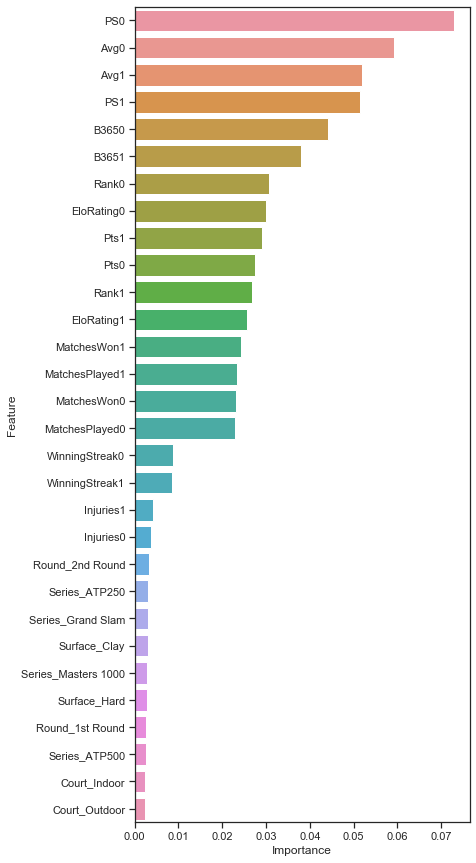

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(6, 15))

sns.barplot(x="Importance", y="Feature", data=plotFeatures)

### Recursive Feature Elimination

In [38]:
from sklearn.feature_selection import RFE

selector = RFE(rf, step=100, n_features_to_select=5)

selector.fit(X,y)


RFE(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                     class_weight=None, criterion='gini',
                                     max_depth=52, max_features='auto',
                                     max_leaf_nodes=None, max_samples=None,
                                     min_impurity_decrease=0.0,
                                     min_impurity_split=None,
                                     min_samples_leaf=1, min_samples_split=10,
                                     min_weight_fraction_leaf=0.0,
                                     n_estimators=50, n_jobs=None,
                                     oob_score=False, random_state=None,
                                     verbose=0, warm_start=False),
    n_features_to_select=5, step=100, verbose=0)

In [39]:
selector.ranking_

array([ 2,  2,  1, ...,  5, 10,  5])

In [40]:
featureImportance['Rank'] = selector.ranking_
plotRank = featureImportance.sort_values(by='Rank').head(n=80)

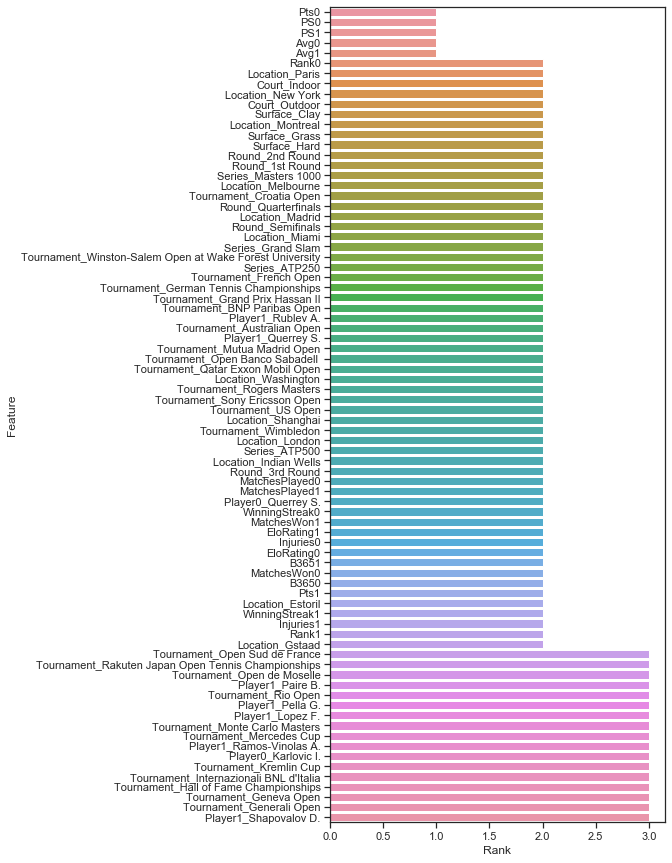

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(6, 15))

sns.barplot(x="Rank", y="Feature", data=plotRank)

As we can see from the two plots the most important features are very similar, we can try to remove all the players columns to see if the accuracy increases

0.6543471675249924


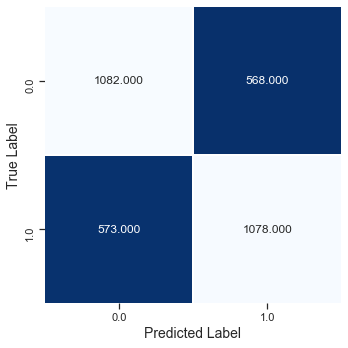

In [42]:
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(n_estimators=50, min_samples_split=10, min_samples_leaf=1, max_features='auto', max_depth=52)
rf.fit(X_train_80, y_train_80)
predicted = rf.predict(X_test)
conf_stat = confusion_matrix(y_true=y_test, y_pred=predicted)

print(accuracy_score(y_true=y_test, y_pred=predicted))

import seaborn as sns

fig, ax = plt.subplots(figsize=(5,5), tight_layout=True)
sns.heatmap(conf_stat, annot=True, fmt=".3f", 
            linewidths=.5, square = True, 
            cmap = 'Blues_r',cbar=False,
            xticklabels=rf.classes_,
            yticklabels=rf.classes_);
ax.set_ylabel('True Label', fontsize=14);
ax.set_xlabel('Predicted Label', fontsize=14);

In [43]:
columns = featureImportance[featureImportance['Rank'] <= 2]['Feature']

X_test = X_test[columns]
X_train_80 = X_train_80[columns]
X_train = X_train[columns]
X_valid = X_valid[columns]

0.6585883065737655


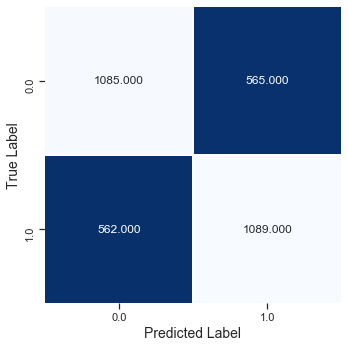

In [44]:
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(n_estimators=50, min_samples_split=10, min_samples_leaf=1, max_features='auto', max_depth=52)
rf.fit(X_train_80, y_train_80)
predicted = rf.predict(X_test)
conf_stat = confusion_matrix(y_true=y_test, y_pred=predicted)

print(accuracy_score(y_true=y_test, y_pred=predicted))

import seaborn as sns

fig, ax = plt.subplots(figsize=(5,5), tight_layout=True)
sns.heatmap(conf_stat, annot=True, fmt=".3f", 
            linewidths=.5, square = True, 
            cmap = 'Blues_r',cbar=False,
            xticklabels=rf.classes_,
            yticklabels=rf.classes_);
ax.set_ylabel('True Label', fontsize=14);
ax.set_xlabel('Predicted Label', fontsize=14);

After removing most of the features the resulting improvement in accuracy is very low (+ 0.061%)

### Clustering
Now we have maximized our classifier accuracy, we move on with clustering. The main purpose is to see if we can determine where our classifier works the best and isolate those cases to bulid a low risk betting strategy.

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(n_estimators=50, min_samples_split=10, min_samples_leaf=1, max_features='auto', max_depth=52)
rf.fit(X_train, y_train)
predicted = rf.predict(X_valid)

In [ ]:
# Apply XOR to find wrongly predicted matches
import numpy as np

wrong_predictions_mask = np.logical_xor(y_valid, predicted)
right_predictions_mask = np.logical_not(np.logical_xor(y_valid, predicted))

wrong_predictions = X_valid[wrong_predictions_mask]
right_predictions = X_valid[right_predictions_mask]

wrong_predictions.head()

In [19]:
from sklearn.cluster import DBSCAN

dbscanR = DBSCAN()
labelsR = dbscanR.fit_predict(X)

# dbscanW = DBSCAN()
# labelsW = dbscanW.fit_predict(wrong_predictions)

Text(0.5, 1.0, 'Right Predictions')

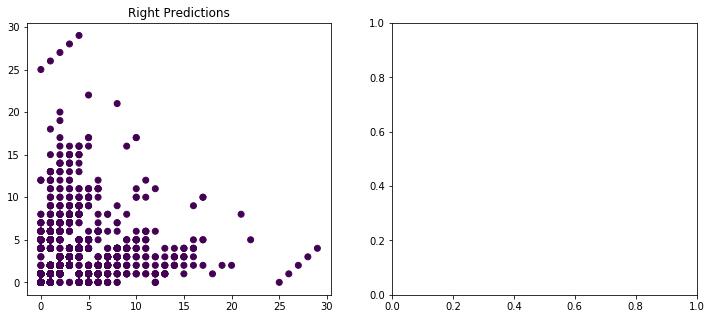

In [20]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=2, figsize=(12,5))

axs[0].scatter(X['WinningStreak1'], X['WinningStreak0'], c=labelsR)
axs[0].set_title("Right Predictions")

# axs[1].scatter(wrong_predictions['WinningStreak1'], wrong_predictions['WinningStreak0'], c=labelsW)
# axs[1].set_title("Wrong Predictions")

In [ ]:
right_predictions[['WinningStreak1', 'WinningStreak0']].head(30)